- Importing MNIST Dataset
- Initializing Random Noise
- Define Generator Model
- Define discriminator model

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
!pip install torchsummary
from torchsummary import summary
from torch.optim import Adam
from torch.nn import BCELoss

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#@ Loading MNSIT Dataset:

transform= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

dl=DataLoader(MNIST('~/data', train=True, download=True, transform=transform), batch_size=128, shuffle=True, drop_last=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 9.62MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.11MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


In [4]:
#@ Defining Random Noise:
def noise(size):
  n=torch.randn(size, 100)
  return n.to(device)

In [5]:
#@ Define Generator Model:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model=nn.Sequential(
        nn.Linear(100, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 784),
        nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

In [6]:
generator=Generator().to(device)
summary(generator, (1, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          25,856
         LeakyReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 512]         131,584
         LeakyReLU-4               [-1, 1, 512]               0
            Linear-5              [-1, 1, 1024]         525,312
         LeakyReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 784]         803,600
              Tanh-8               [-1, 1, 784]               0
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.67
Estimated Total Size (MB): 5.71
----------------------------------------------------------------


In [7]:
#@ Discriminator model:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model=nn.Sequential(
        nn.Linear(784, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [8]:
discriminator=Discriminator().to(device)
summary(discriminator, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]         803,840
         LeakyReLU-2              [-1, 1, 1024]               0
           Dropout-3              [-1, 1, 1024]               0
            Linear-4               [-1, 1, 512]         524,800
         LeakyReLU-5               [-1, 1, 512]               0
           Dropout-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
         LeakyReLU-8               [-1, 1, 256]               0
           Dropout-9               [-1, 1, 256]               0
           Linear-10                 [-1, 1, 1]             257
          Sigmoid-11                 [-1, 1, 1]               0
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [11]:
d_optimizer=torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer=torch.optim.Adam(generator.parameters(), lr=0.0002)
loss=nn.BCELoss()

In [10]:
#@ Function to train discriminator:
def discriminator_train_step(real_data, fake_data):

  d_optimizer.zero_grad() # reseting the gradient

  #prediction on real data:
  prediction_real=discriminator(real_data)
  error_real=loss(prediction_real, torch.ones(len(real_data), 1).to(device))
  error_real.backward()

  #prediction on fake data:
  prediction_fake=discriminator(fake_data)
  error_fake=loss(prediction_fake, torch.ones(len(fake_data), 1).to(device))
  error_fake.backward()

  d_optimizer.step()

  return error_real + error_fake

In [12]:
def generator_train_step(fake_data):
  g_optimizer.zero_grad()
  prediction =discriminator(fake_data)
  error=loss(prediction, torch.ones(len(real_data), 1).to(device))
  error.backward()
  g_optimizer.step()
  return error

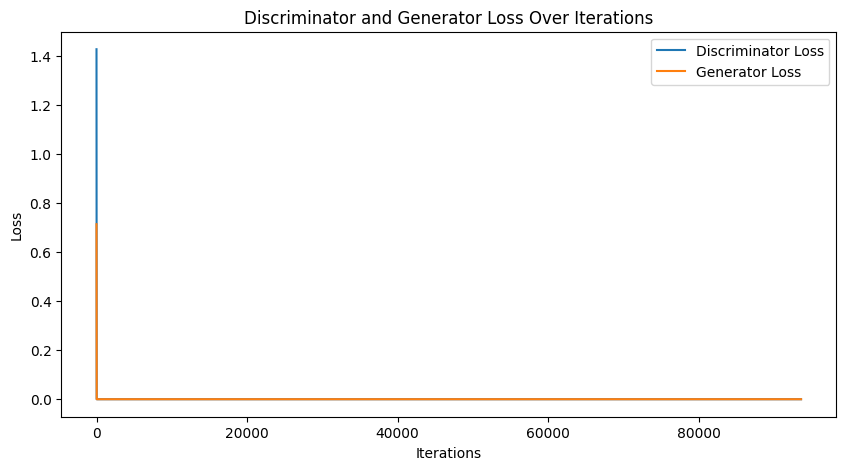

In [13]:
import matplotlib.pyplot as plt

num_epochs = 200
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    N = len(dl)
    for i, (images, _) in enumerate(dl):
        real_data = images.view(len(images), -1).to(device)
        fake_data = generator(noise(len(real_data))).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)

        # Generating a new set of fake images from noisy data
        fake_data = generator(noise(len(real_data))).to(device)
        g_loss = generator_train_step(fake_data)

        # Record losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

# Plot losses over increasing epochs
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Loss Over Iterations")
plt.legend()
plt.show()
